1. LIBRERÍAS - EfficientNet-B4

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import EfficientNet_B4_Weights, efficientnet_b4
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import psutil

2. CONFIGURACIÓN DEL DISPOSITIVO MPS

In [2]:
# Verificar si CUDA está disponible y seleccionar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)

# Imprimir las características de la GPU si CUDA está disponible
if device.type == "cuda":
    print("Nombre de la GPU:", torch.cuda.get_device_name(0))
    print("Capacidad de computo:", torch.cuda.get_device_capability(0))
    print("Memoria total de la GPU: {:.2f} GB".format(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))
    print("Memoria libre: {:.2f} GB".format(torch.cuda.memory_reserved(0) / (1024 ** 3)))
    print("Memoria usada: {:.2f} GB".format(torch.cuda.memory_allocated(0) / (1024 ** 3)))
    print("Multiprocesadores:", torch.cuda.get_device_properties(0).multi_processor_count)
    print("Versión CUDA:", torch.version.cuda)
    print("Versión CuDNN:", torch.backends.cudnn.version())
else:
    print("CUDA no está disponible.")

Dispositivo: cuda
Nombre de la GPU: NVIDIA GeForce RTX 4090
Capacidad de computo: (8, 9)
Memoria total de la GPU: 23.55 GB
Memoria libre: 0.00 GB
Memoria usada: 0.00 GB
Multiprocesadores: 128
Versión CUDA: 12.6
Versión CuDNN: 90501


3. DIRECTORIOS Y TRANSFORMACIONES

In [3]:
data_dir = "/workspace/Training_dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

transform = transforms.Compose([
    transforms.Resize((380, 380)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(15),     
    transforms.ToTensor(),
])

transform_val_test = transforms.Compose([
    transforms.Resize(256),  # Redimensionar a un tamaño más grande para recortar
    transforms.CenterCrop(224),  # Recorte centrado para validación y prueba
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

4. CARGA DE DATOS

In [4]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

5. CARGAR EfficientNet-B4

In [5]:
efficientnet = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, len(class_names))
efficientnet.classifier[0] = nn.Dropout(p=0.7) 
efficientnet = efficientnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=0.001, weight_decay=1e-4) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
early_stopping_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


6. ENTRENAMIENTO Y VALIDACIÓN

In [6]:
train_loss, val_loss, train_acc, val_acc = [], [], [], []
total_time_mps = 0
start_time = time.time()

for epoch in range(100):
    tqdm.write(f"\nEpoch {epoch + 1}/100")
    efficientnet.train()
    running_loss, correct, total = 0.0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Entrenando Epoca {epoch + 1}", unit="lote", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Monitorizar uso de memoria
        if device.type == "cuda":
            memory_used = torch.cuda.memory_allocated(0) / (1024 ** 3)
            memory_reserved = torch.cuda.memory_reserved(0) / (1024 ** 3)
        else:
            memory_info = psutil.virtual_memory()
            memory_used = (memory_info.total - memory_info.available) / (1024 ** 3)
            memory_reserved = memory_info.total / (1024 ** 3)

        train_loader_tqdm.set_postfix({
            'Train Loss': f"{running_loss / (total / labels.size(0)):.4f}",
            'accurate': f"{correct / total:.4f}",
            'Mem Used (GB)': f"{memory_used:.2f}",
            'Mem Reserved (GB)': f"{memory_reserved:.2f}"
        })

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct / total

    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    # Validación
    efficientnet.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = running_loss / len(val_loader)
    epoch_val_acc = correct / total

    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    early_stopping_scheduler.step(epoch_val_loss)

    tqdm.write(f"Epoca {epoch + 1}/100 -> "
               f"Train Loss: {epoch_train_loss:.4f}, "
               f"Val Loss: {epoch_val_loss:.4f}, "
               f"accurate: {epoch_train_acc:.4f}, "
               f"val_accurate: {epoch_val_acc:.4f}, "
               f"Mem Used: {memory_used:.2f} GB, "
               f"Mem Reserved: {memory_reserved:.2f} GB")

end_time = time.time()
training_time = end_time - start_time


Epoch 1/100


Epoca 1/100 -> Train Loss: 0.2407, Val Loss: 0.1406, accurate: 0.9247, val_accurate: 0.9622, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 2/100


Epoca 2/100 -> Train Loss: 0.1246, Val Loss: 0.0936, accurate: 0.9641, val_accurate: 0.9711, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 3/100


Epoca 3/100 -> Train Loss: 0.1219, Val Loss: 0.1544, accurate: 0.9635, val_accurate: 0.9476, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 4/100


Epoca 4/100 -> Train Loss: 0.1088, Val Loss: 0.0789, accurate: 0.9673, val_accurate: 0.9787, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 5/100


Epoca 5/100 -> Train Loss: 0.1032, Val Loss: 0.0689, accurate: 0.9680, val_accurate: 0.9824, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 6/100


Epoca 6/100 -> Train Loss: 0.0925, Val Loss: 0.0733, accurate: 0.9726, val_accurate: 0.9764, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 7/100


Epoca 7/100 -> Train Loss: 0.0906, Val Loss: 0.0531, accurate: 0.9720, val_accurate: 0.9838, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 8/100


Epoca 8/100 -> Train Loss: 0.0747, Val Loss: 0.0751, accurate: 0.9773, val_accurate: 0.9780, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 9/100


Epoca 9/100 -> Train Loss: 0.0796, Val Loss: 0.0886, accurate: 0.9748, val_accurate: 0.9716, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 10/100


Epoca 10/100 -> Train Loss: 0.0694, Val Loss: 0.0648, accurate: 0.9790, val_accurate: 0.9789, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 11/100


Epoca 11/100 -> Train Loss: 0.0638, Val Loss: 0.0548, accurate: 0.9813, val_accurate: 0.9827, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 12/100


Epoca 12/100 -> Train Loss: 0.0588, Val Loss: 0.0636, accurate: 0.9817, val_accurate: 0.9796, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 13/100


Epoca 13/100 -> Train Loss: 0.0627, Val Loss: 0.0632, accurate: 0.9809, val_accurate: 0.9804, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 14/100


Epoca 14/100 -> Train Loss: 0.0546, Val Loss: 0.0638, accurate: 0.9828, val_accurate: 0.9824, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 15/100


Epoca 15/100 -> Train Loss: 0.0562, Val Loss: 0.0429, accurate: 0.9839, val_accurate: 0.9873, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 16/100


Epoca 16/100 -> Train Loss: 0.0573, Val Loss: 0.0490, accurate: 0.9816, val_accurate: 0.9858, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 17/100


Epoca 17/100 -> Train Loss: 0.0541, Val Loss: 0.0671, accurate: 0.9838, val_accurate: 0.9802, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 18/100


Epoca 18/100 -> Train Loss: 0.0544, Val Loss: 0.0664, accurate: 0.9823, val_accurate: 0.9800, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 19/100


Epoca 19/100 -> Train Loss: 0.0526, Val Loss: 0.0601, accurate: 0.9846, val_accurate: 0.9831, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 20/100


Epoca 20/100 -> Train Loss: 0.0517, Val Loss: 0.0423, accurate: 0.9849, val_accurate: 0.9887, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 21/100


Epoca 21/100 -> Train Loss: 0.0487, Val Loss: 0.0479, accurate: 0.9852, val_accurate: 0.9858, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 22/100


Epoca 22/100 -> Train Loss: 0.0473, Val Loss: 0.0463, accurate: 0.9852, val_accurate: 0.9862, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 23/100


Epoca 23/100 -> Train Loss: 0.0476, Val Loss: 0.0399, accurate: 0.9860, val_accurate: 0.9891, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 24/100


Epoca 24/100 -> Train Loss: 0.0450, Val Loss: 0.0531, accurate: 0.9857, val_accurate: 0.9836, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 25/100


Epoca 25/100 -> Train Loss: 0.0437, Val Loss: 0.0500, accurate: 0.9858, val_accurate: 0.9840, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 26/100


Epoca 26/100 -> Train Loss: 0.0445, Val Loss: 0.0475, accurate: 0.9868, val_accurate: 0.9864, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 27/100


Epoca 27/100 -> Train Loss: 0.0436, Val Loss: 0.0603, accurate: 0.9869, val_accurate: 0.9833, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 28/100


Epoca 28/100 -> Train Loss: 0.0466, Val Loss: 0.0459, accurate: 0.9849, val_accurate: 0.9880, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 29/100


Epoca 29/100 -> Train Loss: 0.0415, Val Loss: 0.0328, accurate: 0.9866, val_accurate: 0.9902, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 30/100


Epoca 30/100 -> Train Loss: 0.0412, Val Loss: 0.0544, accurate: 0.9877, val_accurate: 0.9849, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 31/100


Epoca 31/100 -> Train Loss: 0.0359, Val Loss: 0.0877, accurate: 0.9887, val_accurate: 0.9787, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 32/100


Epoca 32/100 -> Train Loss: 0.0442, Val Loss: 0.0477, accurate: 0.9868, val_accurate: 0.9858, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 33/100


Epoca 33/100 -> Train Loss: 0.0396, Val Loss: 0.0411, accurate: 0.9880, val_accurate: 0.9876, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 34/100


Epoca 34/100 -> Train Loss: 0.0386, Val Loss: 0.0419, accurate: 0.9887, val_accurate: 0.9887, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 35/100


Epoca 35/100 -> Train Loss: 0.0445, Val Loss: 0.0500, accurate: 0.9870, val_accurate: 0.9844, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 36/100


Epoca 36/100 -> Train Loss: 0.0449, Val Loss: 0.0486, accurate: 0.9860, val_accurate: 0.9867, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 37/100


Epoca 37/100 -> Train Loss: 0.0397, Val Loss: 0.0455, accurate: 0.9886, val_accurate: 0.9869, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 38/100


Epoca 38/100 -> Train Loss: 0.0355, Val Loss: 0.0534, accurate: 0.9888, val_accurate: 0.9833, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 39/100


Epoca 39/100 -> Train Loss: 0.0355, Val Loss: 0.0467, accurate: 0.9890, val_accurate: 0.9867, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 40/100


Epoca 40/100 -> Train Loss: 0.0352, Val Loss: 0.0606, accurate: 0.9890, val_accurate: 0.9847, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 41/100


Epoca 41/100 -> Train Loss: 0.0203, Val Loss: 0.0262, accurate: 0.9942, val_accurate: 0.9933, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 42/100


Epoca 42/100 -> Train Loss: 0.0140, Val Loss: 0.0303, accurate: 0.9965, val_accurate: 0.9924, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 43/100


Epoca 43/100 -> Train Loss: 0.0178, Val Loss: 0.0316, accurate: 0.9949, val_accurate: 0.9907, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 44/100


Epoca 44/100 -> Train Loss: 0.0174, Val Loss: 0.0278, accurate: 0.9946, val_accurate: 0.9916, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 45/100


Epoca 45/100 -> Train Loss: 0.0186, Val Loss: 0.0302, accurate: 0.9948, val_accurate: 0.9922, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 46/100


Epoca 46/100 -> Train Loss: 0.0172, Val Loss: 0.0309, accurate: 0.9948, val_accurate: 0.9931, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 47/100


Epoca 47/100 -> Train Loss: 0.0166, Val Loss: 0.0254, accurate: 0.9952, val_accurate: 0.9929, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 48/100


Epoca 48/100 -> Train Loss: 0.0170, Val Loss: 0.0322, accurate: 0.9948, val_accurate: 0.9916, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 49/100


Epoca 49/100 -> Train Loss: 0.0182, Val Loss: 0.0271, accurate: 0.9943, val_accurate: 0.9929, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 50/100


Epoca 50/100 -> Train Loss: 0.0180, Val Loss: 0.0335, accurate: 0.9948, val_accurate: 0.9902, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 51/100


Epoca 51/100 -> Train Loss: 0.0174, Val Loss: 0.0340, accurate: 0.9946, val_accurate: 0.9902, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 52/100


Epoca 52/100 -> Train Loss: 0.0179, Val Loss: 0.0285, accurate: 0.9945, val_accurate: 0.9922, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 53/100


Epoca 53/100 -> Train Loss: 0.0189, Val Loss: 0.0281, accurate: 0.9945, val_accurate: 0.9924, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 54/100


Epoca 54/100 -> Train Loss: 0.0154, Val Loss: 0.0372, accurate: 0.9962, val_accurate: 0.9909, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 55/100


Epoca 55/100 -> Train Loss: 0.0170, Val Loss: 0.0293, accurate: 0.9948, val_accurate: 0.9918, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 56/100


Epoca 56/100 -> Train Loss: 0.0177, Val Loss: 0.0384, accurate: 0.9950, val_accurate: 0.9911, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 57/100


Epoca 57/100 -> Train Loss: 0.0148, Val Loss: 0.0334, accurate: 0.9960, val_accurate: 0.9922, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 58/100


Epoca 58/100 -> Train Loss: 0.0169, Val Loss: 0.0274, accurate: 0.9952, val_accurate: 0.9922, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 59/100


Epoca 59/100 -> Train Loss: 0.0103, Val Loss: 0.0338, accurate: 0.9971, val_accurate: 0.9927, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 60/100


Epoca 60/100 -> Train Loss: 0.0092, Val Loss: 0.0247, accurate: 0.9980, val_accurate: 0.9947, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 61/100


Epoca 61/100 -> Train Loss: 0.0085, Val Loss: 0.0256, accurate: 0.9978, val_accurate: 0.9942, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 62/100


Epoca 62/100 -> Train Loss: 0.0071, Val Loss: 0.0262, accurate: 0.9983, val_accurate: 0.9936, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 63/100


Epoca 63/100 -> Train Loss: 0.0065, Val Loss: 0.0251, accurate: 0.9983, val_accurate: 0.9944, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 64/100


Epoca 64/100 -> Train Loss: 0.0095, Val Loss: 0.0270, accurate: 0.9973, val_accurate: 0.9936, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 65/100


Epoca 65/100 -> Train Loss: 0.0066, Val Loss: 0.0261, accurate: 0.9986, val_accurate: 0.9949, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 66/100


Epoca 66/100 -> Train Loss: 0.0111, Val Loss: 0.0292, accurate: 0.9969, val_accurate: 0.9920, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 67/100


Epoca 67/100 -> Train Loss: 0.0085, Val Loss: 0.0268, accurate: 0.9975, val_accurate: 0.9940, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 68/100


Epoca 68/100 -> Train Loss: 0.0066, Val Loss: 0.0287, accurate: 0.9984, val_accurate: 0.9931, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 69/100


Epoca 69/100 -> Train Loss: 0.0087, Val Loss: 0.0316, accurate: 0.9977, val_accurate: 0.9933, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 70/100


Epoca 70/100 -> Train Loss: 0.0078, Val Loss: 0.0295, accurate: 0.9978, val_accurate: 0.9940, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 71/100


Epoca 71/100 -> Train Loss: 0.0083, Val Loss: 0.0272, accurate: 0.9978, val_accurate: 0.9929, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 72/100


Epoca 72/100 -> Train Loss: 0.0058, Val Loss: 0.0267, accurate: 0.9984, val_accurate: 0.9936, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 73/100


Epoca 73/100 -> Train Loss: 0.0043, Val Loss: 0.0268, accurate: 0.9990, val_accurate: 0.9933, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 74/100


Epoca 74/100 -> Train Loss: 0.0047, Val Loss: 0.0302, accurate: 0.9990, val_accurate: 0.9933, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 75/100


Epoca 75/100 -> Train Loss: 0.0044, Val Loss: 0.0231, accurate: 0.9991, val_accurate: 0.9940, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 76/100


Epoca 76/100 -> Train Loss: 0.0043, Val Loss: 0.0225, accurate: 0.9990, val_accurate: 0.9951, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 77/100


Epoca 77/100 -> Train Loss: 0.0052, Val Loss: 0.0293, accurate: 0.9987, val_accurate: 0.9924, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 78/100


Epoca 78/100 -> Train Loss: 0.0040, Val Loss: 0.0242, accurate: 0.9992, val_accurate: 0.9942, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 79/100


Epoca 79/100 -> Train Loss: 0.0046, Val Loss: 0.0239, accurate: 0.9991, val_accurate: 0.9942, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 80/100


Epoca 80/100 -> Train Loss: 0.0048, Val Loss: 0.0332, accurate: 0.9987, val_accurate: 0.9929, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 81/100


Epoca 81/100 -> Train Loss: 0.0049, Val Loss: 0.0285, accurate: 0.9989, val_accurate: 0.9931, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 82/100


Epoca 82/100 -> Train Loss: 0.0053, Val Loss: 0.0283, accurate: 0.9987, val_accurate: 0.9936, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 83/100


Epoca 83/100 -> Train Loss: 0.0052, Val Loss: 0.0239, accurate: 0.9990, val_accurate: 0.9936, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 84/100


Epoca 84/100 -> Train Loss: 0.0058, Val Loss: 0.0221, accurate: 0.9990, val_accurate: 0.9949, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 85/100


Epoca 85/100 -> Train Loss: 0.0050, Val Loss: 0.0265, accurate: 0.9990, val_accurate: 0.9944, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 86/100


Epoca 86/100 -> Train Loss: 0.0042, Val Loss: 0.0198, accurate: 0.9992, val_accurate: 0.9958, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 87/100


Epoca 87/100 -> Train Loss: 0.0038, Val Loss: 0.0266, accurate: 0.9990, val_accurate: 0.9933, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 88/100


Epoca 88/100 -> Train Loss: 0.0049, Val Loss: 0.0273, accurate: 0.9989, val_accurate: 0.9936, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 89/100


Epoca 89/100 -> Train Loss: 0.0038, Val Loss: 0.0207, accurate: 0.9993, val_accurate: 0.9944, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 90/100


Epoca 90/100 -> Train Loss: 0.0054, Val Loss: 0.0268, accurate: 0.9989, val_accurate: 0.9940, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 91/100


Epoca 91/100 -> Train Loss: 0.0052, Val Loss: 0.0233, accurate: 0.9989, val_accurate: 0.9936, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 92/100


Epoca 92/100 -> Train Loss: 0.0050, Val Loss: 0.0230, accurate: 0.9989, val_accurate: 0.9949, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 93/100


Epoca 93/100 -> Train Loss: 0.0053, Val Loss: 0.0258, accurate: 0.9992, val_accurate: 0.9942, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 94/100


Epoca 94/100 -> Train Loss: 0.0063, Val Loss: 0.0229, accurate: 0.9983, val_accurate: 0.9942, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 95/100


Epoca 95/100 -> Train Loss: 0.0033, Val Loss: 0.0217, accurate: 0.9995, val_accurate: 0.9947, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 96/100


Epoca 96/100 -> Train Loss: 0.0046, Val Loss: 0.0270, accurate: 0.9990, val_accurate: 0.9947, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 97/100


Epoca 97/100 -> Train Loss: 0.0055, Val Loss: 0.0287, accurate: 0.9988, val_accurate: 0.9936, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 98/100


Epoca 98/100 -> Train Loss: 0.0038, Val Loss: 0.0257, accurate: 0.9992, val_accurate: 0.9942, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 99/100


Epoca 99/100 -> Train Loss: 0.0034, Val Loss: 0.0261, accurate: 0.9995, val_accurate: 0.9944, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB

Epoch 100/100


Epoca 100/100 -> Train Loss: 0.0032, Val Loss: 0.0234, accurate: 0.9995, val_accurate: 0.9940, Mem Used: 0.30 GB, Mem Reserved: 21.10 GB


 7. GUARDAR EL MODELO

In [7]:
torch.save(efficientnet.state_dict(), "/workspace/Models/EfficientNet_B4_model.pth")

8. VALIDACIÓN EN EL CONJUNTO DE PRUEBA

In [9]:
os.makedirs("EfficientNet_B4", exist_ok=True)

# Configurar el modelo en modo evaluación
efficientnet.eval()
y_true, y_pred = [], []
embeddings = []

with torch.no_grad():
    for images, labels in test_loader:
        # Mover datos a la GPU si está disponible
        images, labels = images.to(device), labels.to(device)
        
        # Extraer embeddings y mover a la CPU
        features = efficientnet.features(images)
        embeddings.append(features.view(features.size(0), -1).detach().cpu().numpy())
        
        # Generar predicciones
        outputs = efficientnet(images)
        _, preds = torch.max(outputs, 1)
        
        # Mover predicciones y etiquetas a la CPU
        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())

# Concatenar embeddings y convertirlos a un array
embeddings = np.concatenate(embeddings)

# Generar reporte de clasificación
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Guardar reporte en un archivo Excel
report_df.to_excel("/workspace/EfficientNet_B4/Metricas_EfficientNetB4.xlsx")

print("Reporte guardado en: EfficientNet_B4/Metricas_EfficientNetB4.xlsx")


Reporte guardado en: EfficientNet_B4/Metricas_EfficientNetB4.xlsx


 9. MATRIZ DE CONFUSIÓN

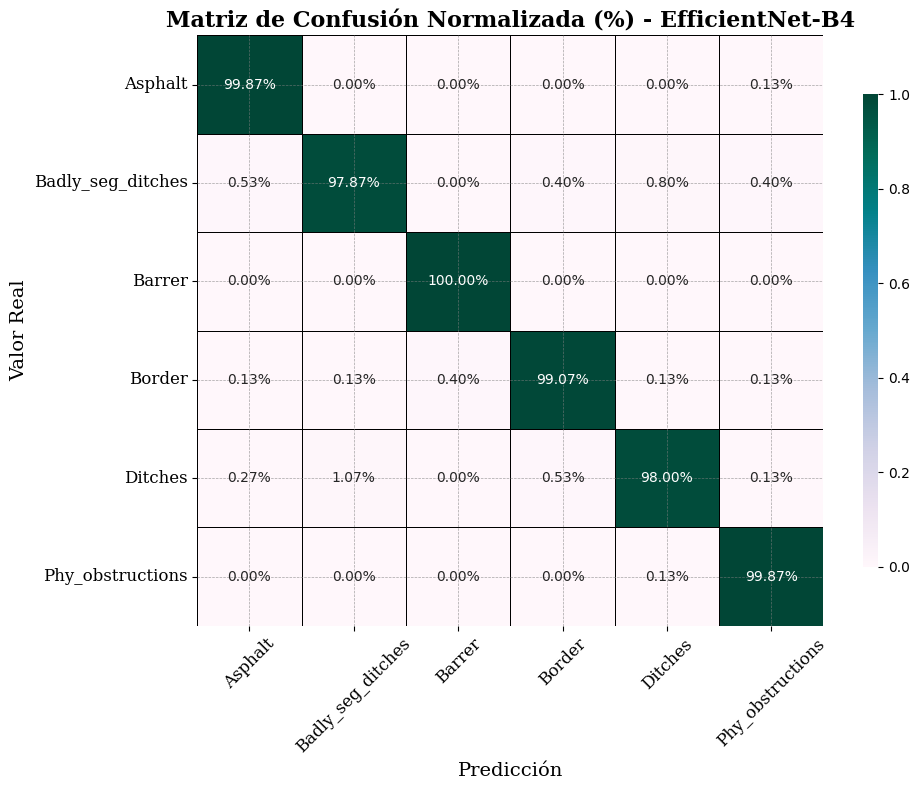

Matriz de confusión guardada en 'EfficientNet_B4'.


In [ ]:
# Calcular la matriz de confusión y normalizarla
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_norm,
    annot=True,
    fmt='.2%',
    cmap='PuBuGn',  
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,
    linecolor='black',
    cbar_kws={'aspect': 30, 'shrink': 0.8}  
)

# Títulos y etiquetas
plt.title('Matriz de Confusión Normalizada (%) - EfficientNet-B4', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Predicción', fontsize=14, family='serif')
plt.ylabel('Valor Real', fontsize=14, family='serif')
plt.xticks(rotation=45, fontsize=12, family='serif')
plt.yticks(rotation=0, fontsize=12, family='serif')

# Ajustes adicionales
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Guardar el gráfico
plt.savefig("/workspace/EfficientNet_B4/Matriz_confusion.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("/workspace/EfficientNet_B4/Matriz_confusion.png", dpi=300, bbox_inches='tight')
plt.show()

print("Matriz de confusión guardada en 'EfficientNet_B4'.")

10. GRAFICAR MÉTRICAS

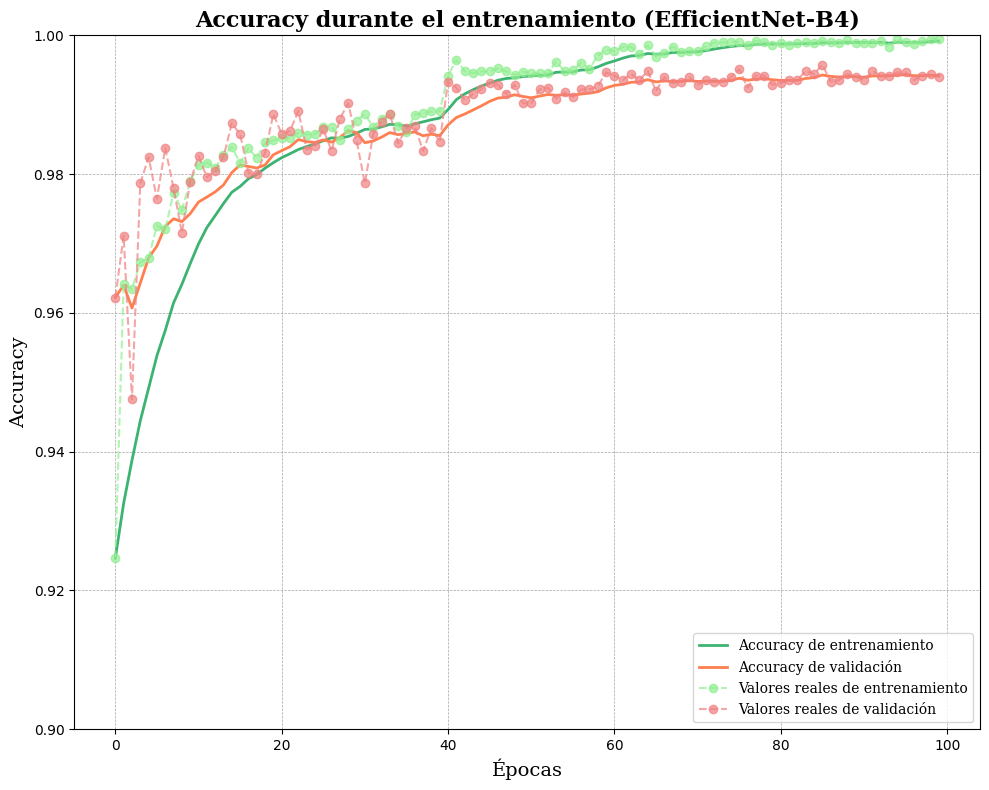

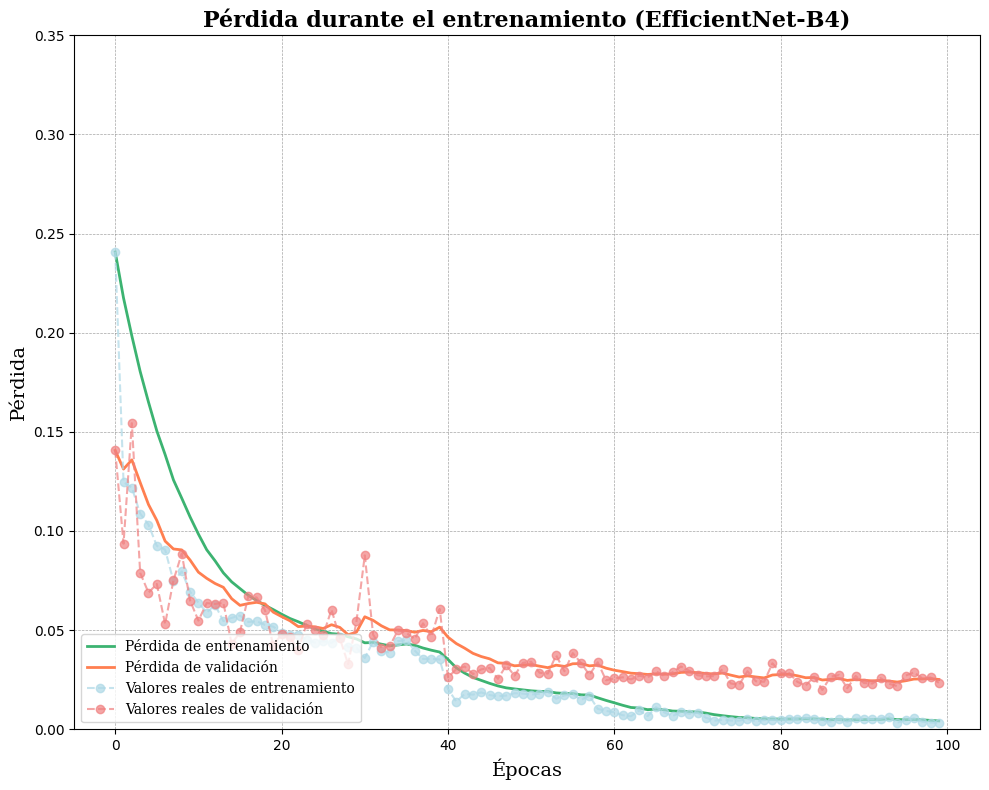

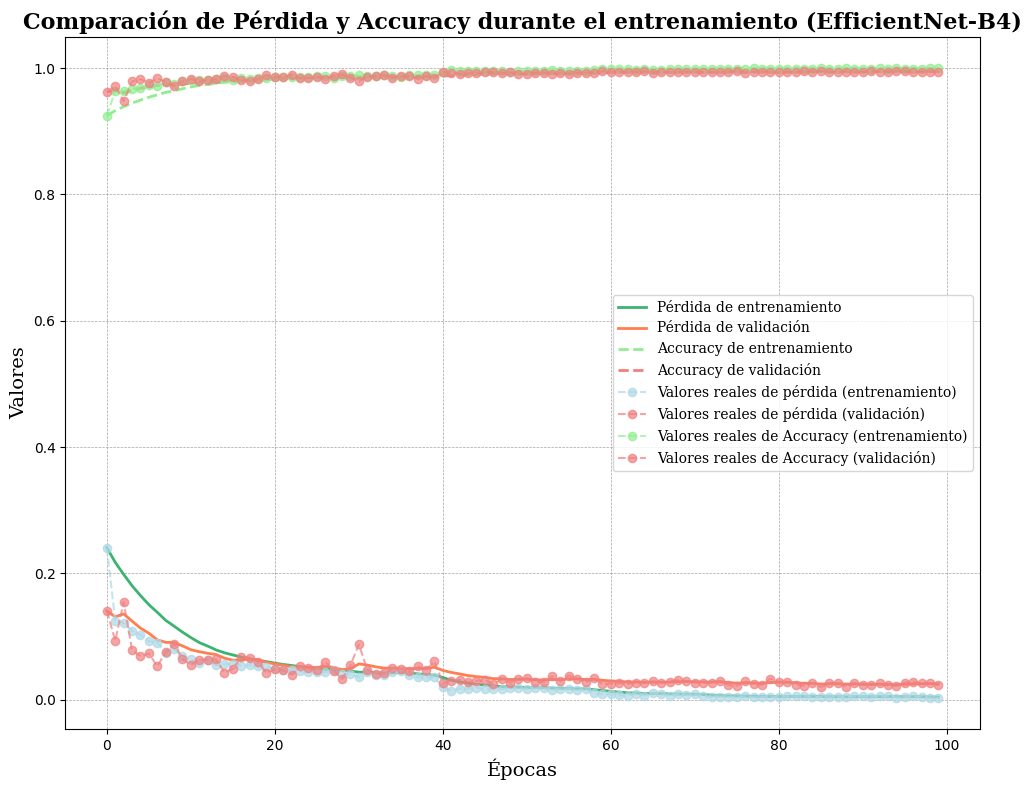

In [11]:
def suavizar(valores, peso=0.8):
    smoothed = []
    ultimo = valores[0]
    for punto in valores:
        smoothed_val = ultimo * peso + (1 - peso) * punto
        smoothed.append(smoothed_val)
        ultimo = smoothed_val
    return smoothed

train_acc_smooth = suavizar(train_acc)
val_acc_smooth = suavizar(val_acc)
train_loss_smooth = suavizar(train_loss)
val_loss_smooth = suavizar(val_loss)

# Gráfica 1: Accuracy durante el entrenamiento
plt.figure(figsize=(10, 8))
plt.plot(train_acc_smooth, label='Accuracy de entrenamiento', linestyle='-', linewidth=2, color='mediumseagreen')
plt.plot(val_acc_smooth, label='Accuracy de validación', linestyle='-', linewidth=2, color='coral')
plt.plot(train_acc, 'o--', alpha=0.7, color='lightgreen', label='Valores reales de entrenamiento')
plt.plot(val_acc, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de validación')
plt.xlabel('Épocas', fontsize=14, family='serif')
plt.ylabel('Accuracy', fontsize=14, family='serif')
plt.title('Accuracy durante el entrenamiento (EfficientNet-B4)', fontsize=16, fontweight='bold', family='serif')
plt.ylim([0.9, 1.0])
plt.legend(loc='lower right', fontsize=12, prop={'family': 'serif'})
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("/workspace/EfficientNet_B4/Accuracy_EfficientNet_B4.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("/workspace/EfficientNet_B4/Accuracy_EfficientNet_B4.png", dpi=300, bbox_inches='tight')
plt.show()

# Gráfica 2: Pérdida durante el entrenamiento
plt.figure(figsize=(10, 8))
plt.plot(train_loss_smooth, label='Pérdida de entrenamiento', linestyle='-', linewidth=2, color='mediumseagreen')
plt.plot(val_loss_smooth, label='Pérdida de validación', linestyle='-', linewidth=2, color='coral')
plt.plot(train_loss, 'o--', alpha=0.7, color='lightblue', label='Valores reales de entrenamiento')
plt.plot(val_loss, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de validación')
plt.xlabel('Épocas', fontsize=14, family='serif')
plt.ylabel('Pérdida', fontsize=14, family='serif')
plt.title('Pérdida durante el entrenamiento (EfficientNet-B4)', fontsize=16, fontweight='bold', family='serif')
plt.ylim([0, 0.35])
plt.legend(loc='lower left', fontsize=12, prop={'family': 'serif'})
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("/workspace/EfficientNet_B4/Perdida_EfficientNet_B4.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("/workspace/EfficientNet_B4/Perdida_EfficientNet_B4.png", dpi=300, bbox_inches='tight')
plt.show()

# Gráfica 3: Comparación de Pérdida y Accuracy durante el entrenamiento
plt.figure(figsize=(10, 8))
plt.plot(train_loss_smooth, label='Pérdida de entrenamiento', linestyle='-', linewidth=2, color='mediumseagreen')
plt.plot(val_loss_smooth, label='Pérdida de validación', linestyle='-', linewidth=2, color='coral')
plt.plot(train_acc_smooth, label='Accuracy de entrenamiento', linestyle='--', linewidth=2, color='lightgreen')
plt.plot(val_acc_smooth, label='Accuracy de validación ', linestyle='--', linewidth=2, color='lightcoral')
plt.plot(train_loss, 'o--', alpha=0.7, color='lightblue', label='Valores reales de pérdida (entrenamiento)')
plt.plot(val_loss, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de pérdida (validación)')
plt.plot(train_acc, 'o--', alpha=0.7, color='lightgreen', label='Valores reales de Accuracy (entrenamiento)')
plt.plot(val_acc, 'o--', alpha=0.7, color='lightcoral', label='Valores reales de Accuracy (validación)')
plt.xlabel('Épocas', fontsize=14, family='serif')
plt.ylabel('Valores', fontsize=14, family='serif')
plt.title('Comparación de Pérdida y Accuracy durante el entrenamiento (EfficientNet-B4)', fontsize=16, fontweight='bold', family='serif')
plt.legend(loc='best', fontsize=12, prop={'family': 'serif'})
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("/workspace/EfficientNet_B4/Comparacion_Perdida_Accuracy_EfficientNet_B4.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("/workspace/EfficientNet_B4/Comparacion_Perdida_Accuracy_EfficientNet_B4.png", dpi=300, bbox_inches='tight')
plt.show()


11. ANÁLISIS DE VECTORES (Vector Analysis)

Generando análisis de vectores...
Tamaño de f1_scores: 4500
Forma de embeddings antes de reshape: (4500, 258048)
Forma de embeddings después de reshape: (4500, 258048)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Tamaño de embeddings_2d: (4500, 2)
Tamaño de f1_scores: 4500


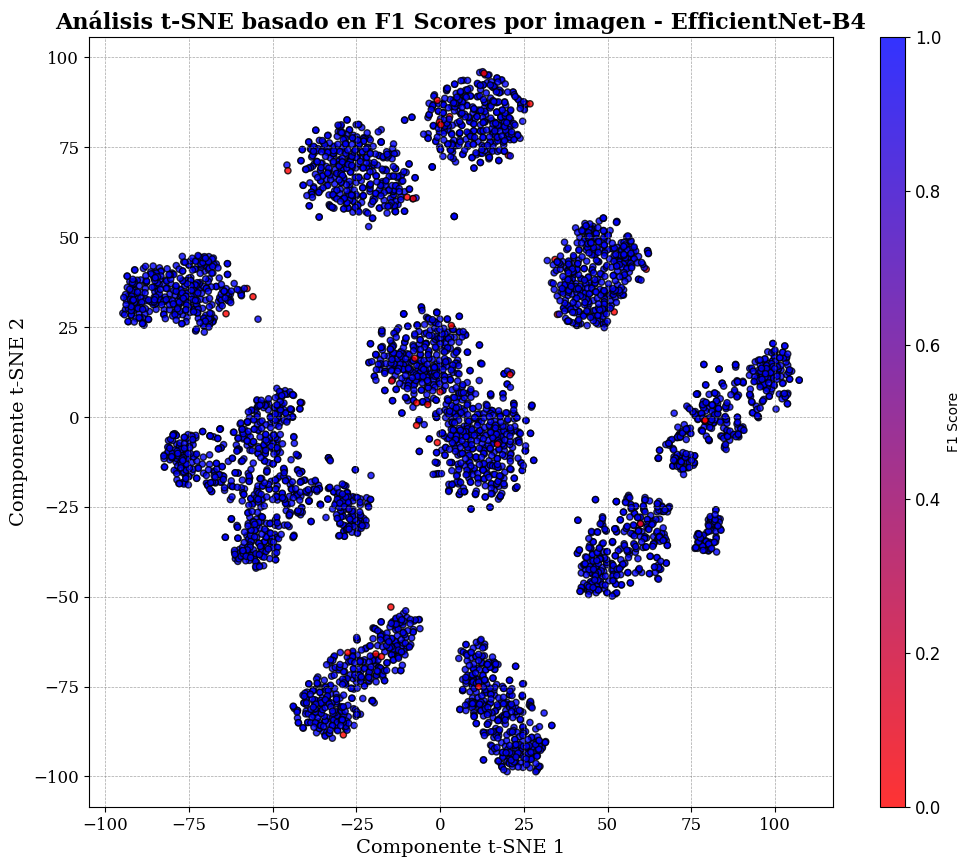

Análisis de vectores completado. Resultados guardados en '/workspace/EfficientNet_B4'.


In [ ]:
import matplotlib.colors as mcolors
from matplotlib import colors as mcolors  # Corregido

# Crear una colormap personalizada: azul para la mayoría y rojo para outliers
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['red', 'blue'])
print("Generando análisis de vectores...")

efficientnet.eval()
y_true, y_pred, embeddings = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Extraer y almacenar embeddings
        features = efficientnet.features(images)
        embeddings.append(features.view(features.size(0), -1).cpu().numpy())

# Unificar embeddings en una matriz NumPy
embeddings = np.concatenate(embeddings)

# Calcular F1 Scores por imagen
f1_scores = [f1_score([true], [pred], average='weighted') for true, pred in zip(y_true, y_pred)]
print("Tamaño de f1_scores:", len(f1_scores))

# Verificar y ajustar la forma de embeddings
print("Forma de embeddings antes de reshape:", embeddings.shape)
if len(embeddings.shape) == 1:
    embeddings = embeddings.reshape(-1, 1)
print("Forma de embeddings después de reshape:", embeddings.shape)

# Aplicar t-SNE con parámetros ajustados
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
embeddings_2d = tsne.fit_transform(embeddings)

print("Tamaño de embeddings_2d:", embeddings_2d.shape)
print("Tamaño de f1_scores:", len(f1_scores))

# Crear una colormap personalizada: azul para la mayoría y rojo para outliers
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['red', 'blue'])

# Generar el gráfico t-SNE con la paleta personalizada
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    x=embeddings_2d[:, 0], 
    y=embeddings_2d[:, 1], 
    c=f1_scores, 
    cmap=cmap, 
    s=20,            
    alpha=0.8,       
    edgecolor='k'    
)
cbar = plt.colorbar(scatter, label='F1 Score', aspect=30)
cbar.ax.tick_params(labelsize=12)

# Personalización avanzada del gráfico
plt.title('Análisis t-SNE basado en F1 Scores por imagen - EfficientNet-B4', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Componente t-SNE 1', fontsize=14, family='serif')
plt.ylabel('Componente t-SNE 2', fontsize=14, family='serif')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12, family='serif')
plt.yticks(fontsize=12, family='serif')

# Guardar el gráfico en formato SVG para alta calidad en presentaciones
plt.savefig("/workspace/EfficientNet_B4/Vector_Analysis_EfficientNet_B4_RB.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig("/workspace/EfficientNet_B4/Vector_Analysis_EfficientNet_B4_RB.png", dpi=300, bbox_inches='tight')
plt.show()

# Guardar los datos procesados
df_embeddings = pd.DataFrame(embeddings_2d, columns=['Componente_1', 'Componente_2'])
df_embeddings['F1_Score'] = f1_scores
df_embeddings.to_csv("/workspace/EfficientNet_B4/Embeddings_y_F1Scores_Red_Blue.csv", index=False)

print("Análisis de vectores completado. Resultados guardados en '/workspace/EfficientNet_B4'.")

12. EVALUACIÓN EN EL CONJUNTO DE PRUEBA

Generando predicciones y calculando scores...


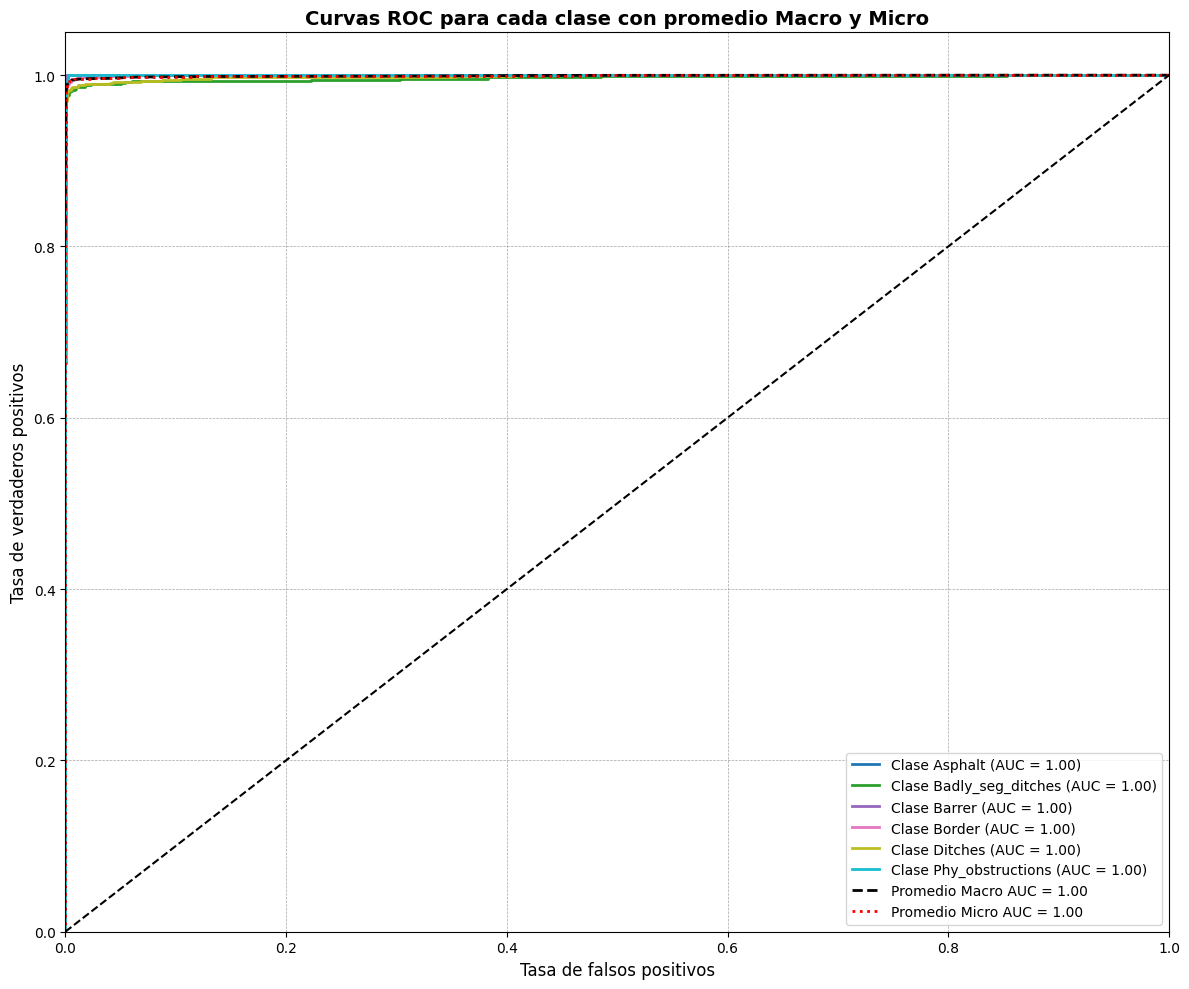

Curvas ROC generadas y guardadas en 'EfficientNet_B4'.


In [16]:
print("Generando predicciones y calculando scores...")
efficientnet.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet(images)
        y_scores.extend(outputs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Preparación de Datos para la Curva ROC
y_scores = np.array(y_scores)
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Cálculo de Promedio Macro y Micro AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
micro_auc = auc(fpr_micro, tpr_micro)

# Generación del Gráfico de Curvas ROC
plt.figure(figsize=(12, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
             label=f'Clase {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Agregar curvas promedio Macro y Micro
plt.plot(all_fpr, mean_tpr, linestyle='--', color='black', linewidth=2,
         label=f'Promedio Macro AUC = {macro_auc:.2f}')
plt.plot(fpr_micro, tpr_micro, linestyle=':', color='red', linewidth=2,
         label=f'Promedio Micro AUC = {micro_auc:.2f}')

# Configuración Avanzada del Gráfico
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos', fontsize=12)
plt.ylabel('Tasa de verdaderos positivos', fontsize=12)
plt.title('Curvas ROC para cada clase con promedio Macro y Micro', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Guardar el gráfico con alta resolución
plt.tight_layout()
plt.savefig("/workspace/EfficientNet_B4/Curva_ROC_AUC.png", dpi=300, bbox_inches='tight')
plt.show()

# Crear listas separadas para clases, AUC y tipo
clases = class_names + ['Promedio Macro', 'Promedio Micro']
auc_scores = [roc_auc[i] for i in range(len(class_names))] + [macro_auc, micro_auc]
tipo = ['Individual'] * len(class_names) + ['Promedio Macro', 'Promedio Micro']

# Asegurar que todas las listas tengan la misma longitud
assert len(clases) == len(auc_scores) == len(tipo), "Las listas no tienen la misma longitud"

# Crear el DataFrame corregido
roc_data = {
    'Clase': clases,
    'AUC': auc_scores,
    'Tipo': tipo
}
df_roc = pd.DataFrame(roc_data)
df_roc.to_csv("/workspace/EfficientNet_B4/Curvas_ROC_AUC_Resumen.csv", index=False)

print("Curvas ROC generadas y guardadas en 'EfficientNet_B4'.")

13. GUARDAR INFORME

In [17]:
with open("/workspace/EfficientNet_B4/Detalles_entrenamiento_EfficientNet_B4.txt", "w") as f:
    f.write(f"Tiempo total de entrenamiento: {training_time:.2f} segundos\n")
    f.write(f"Dispositivo: {device}\n")
    f.write("Modelo: EfficientNet-B4\n")
    f.write("Directorio del modelo: /workspace/Models/EfficientNet_B4_model.pth\n")
    f.write(f"Parámetros: {sum(p.numel() for p in efficientnet.parameters())}\n")
    f.write("Métricas:\n")
    f.write(report_df.to_string())
    f.write("\n\nMatriz de Confusión guardada en: /workspace/EfficientNet_B4/Matriz_confusion_EfficientNet_B4.png\n")
    f.write("Análisis de Vectores guardado en: /workspace/EfficientNet_B4/Vector_Analysis_EfficientNet_B4.png\n")

print("Entrenamiento y evaluación completados. Resultados guardados en '/workspace/EfficientNet_B4'.")

Entrenamiento y evaluación completados. Resultados guardados en '/workspace/EfficientNet_B4'.
